In [1]:
from keras.layers import Dense, Dropout, Activation, Flatten, Lambda, BatchNormalization, merge, Conv2D
import numpy as np
from keras.layers import Dense, Dropout, Activation, Flatten, Lambda, BatchNormalization, merge, Conv2D
import keras.backend as K
from keras.layers import Convolution2D, MaxPooling2D, AveragePooling2D,BatchNormalization
from keras.layers.merge import concatenate
from keras.layers import add
from keras.layers import Input,GlobalAveragePooling2D
import keras
from keras.models import  Model
from keras.preprocessing.image import  ImageDataGenerator
import keras.callbacks as kcallbacks
import math
from keras.utils import plot_model

Using TensorFlow backend.


In [2]:
#写一个LossHistory类，保存loss和acc
class LossHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.losses = {'batch':[], 'epoch':[]}
        self.accuracy = {'batch':[], 'epoch':[]}
        self.val_loss = {'batch':[], 'epoch':[]}
        self.val_acc = {'batch':[], 'epoch':[]}
    def on_batch_end(self, batch, logs={}):
        self.losses['batch'].append(logs.get('loss'))
        self.accuracy['batch'].append(logs.get('acc'))
        self.val_loss['batch'].append(logs.get('val_loss'))
        self.val_acc['batch'].append(logs.get('val_acc'))
    def on_epoch_end(self, batch, logs={}):
        self.losses['epoch'].append(logs.get('loss'))
        self.accuracy['epoch'].append(logs.get('acc'))
        self.val_loss['epoch'].append(logs.get('val_loss'))
        self.val_acc['epoch'].append(logs.get('val_acc'))
    def loss_plot(self, loss_type):
        iters = range(len(self.losses[loss_type]))
        plt.figure()
        plt.plot(iters, self.losses[loss_type], 'g', label='train loss')
        if loss_type == 'epoch':
            # acc
            plt.plot(iters, self.accuracy[loss_type], 'r', label='train acc')
            # loss
            plt.plot(iters, self.losses[loss_type], 'g', label='train loss')
            # val_acc
            plt.plot(iters, self.val_acc[loss_type], 'b', label='val acc')
            # val_loss
            plt.plot(iters, self.val_loss[loss_type], 'k', label='val loss')
        plt.grid(True)
        plt.xlabel(loss_type)
        plt.ylabel('acc-loss')
        plt.legend(loc="upper right")
        plt.show()

In [3]:
#创建一个实例来存储history
history = LossHistory()

In [4]:
def conv_block_with_maxpool(input_img):
    tower_1 = Conv2D(32, (1, 1), padding='same', activation='relu')(input_img)
    tower_1=MaxPooling2D()(tower_1)
    tower_1 = Conv2D(64, (3, 3), padding='same', activation='relu')(tower_1)
    tower_1=MaxPooling2D()(tower_1)
    tower_2 = Conv2D(64, (1, 1), padding='same', activation='relu')(input_img)
    tower_2=MaxPooling2D()(tower_2)
    tower_2 = Conv2D(64, (3, 3), padding='same', activation='relu')(tower_2)
    tower_2=MaxPooling2D()(tower_2)
    tower_3 = Conv2D(128, (1, 1), padding='same', activation='relu')(input_img)
    tower_3=MaxPooling2D()(tower_3)
    tower_3 = Conv2D(64, (3, 3), padding='same', activation='relu')(tower_3)
    tower_3=MaxPooling2D()(tower_3)
    output = keras.layers.concatenate([tower_1, tower_2, tower_3], axis=-1)
    return output

In [5]:
def conv_block(input_img):
    tower_1 = Conv2D(32, (1, 1), padding='same', activation='relu')(input_img)
    tower_1 = Conv2D(64, (3, 3), padding='same', activation='relu')(tower_1)
    tower_2 = Conv2D(64, (1, 1), padding='same', activation='relu')(input_img)
    tower_2 = Conv2D(64, (3, 3), padding='same', activation='relu')(tower_2)
    tower_3 = Conv2D(128, (1, 1), padding='same', activation='relu')(input_img)
    tower_3 = Conv2D(64, (3, 3), padding='same', activation='relu')(tower_3)
    output = keras.layers.concatenate([tower_1, tower_2, tower_3], axis=-1)
    return output

In [6]:
def resnet(input_img):
    shortcut=input_img
    x=conv_block(input_img)
    x=add([shortcut,x])
    x=Activation('relu')(x)
    return x

In [7]:
inputs = Input(shape=(512, 512, 3))
x=Conv2D(32,(3,3),padding='valid',activation='relu')(inputs)
x=BatchNormalization()(x)
x=MaxPooling2D()(x)
x=conv_block_with_maxpool(x)
x=resnet(x)
x=resnet(x)
x=resnet(x)
x=resnet(x)
x=resnet(x)
x=BatchNormalization()(x)
x = GlobalAveragePooling2D()(x)
x=Dense(128,activation='relu')(x)
x=Dropout(0.2)(x)
x=Dense(64,activation='relu')(x)
x=Dropout(0.2)(x)
predictions=Dense(5,activation='softmax')(x)

In [8]:
model =Model(inputs=inputs,outputs=predictions)
plot_model(model=model,to_file='./own_network_model.jpg')

In [9]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 512, 512, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 510, 510, 32) 896         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 510, 510, 32) 128         conv2d_1[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 255, 255, 32) 0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_2 (

In [10]:
TARGET_SIZE=(512,512)
INPUT_SIZE=(512,512,3)
BATCHSIZE=16
##################################
train_datagen = ImageDataGenerator(rescale=1./255)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        './train/',
        target_size=TARGET_SIZE,
        batch_size=BATCHSIZE,
        class_mode='categorical')
validation_generator = test_datagen.flow_from_directory(
        './test/',
        target_size=TARGET_SIZE,
        batch_size=BATCHSIZE,
        class_mode='categorical')

Found 49658 images belonging to 5 classes.
Found 10000 images belonging to 5 classes.


In [11]:
savepath='./mymodel.h5'
epochs=30
#定义一下优化的方法
opt = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
#compile一下模型
model.compile(loss='categorical_crossentropy',optimizer=opt,metrics=['accuracy'])
#train model
earlyStopping=kcallbacks.EarlyStopping(monitor='val_acc', patience=3, verbose=1, mode='auto')
saveBestModel = kcallbacks.ModelCheckpoint(filepath=savepath, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')
#     model_vgg19_clair.fit(X_train_vgg,y_train,batch_size=batchsize,epochs=epochs,verbose=1,
#               validation_data=(X_test_vgg,y_test),shuffle=True,callbacks=[earlyStopping,saveBestModel])
hist=model.fit_generator(
    train_generator,
    steps_per_epoch=math.ceil(49658/BATCHSIZE),
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=math.ceil(10000/BATCHSIZE),
    callbacks=[earlyStopping,saveBestModel,history],
    workers=8
)
with open('own_model_log.txt','w') as f:
    f.write(str(hist.history))

Epoch 1/30
3104/3104 [==============================] - 1878s 605ms/step - loss: 1.2394 - acc: 0.5019 - val_loss: 1.2017 - val_acc: 0.5399
Epoch 2/30
3104/3104 [==============================] - 1876s 604ms/step - loss: 1.0954 - acc: 0.5541 - val_loss: 1.1212 - val_acc: 0.5483
Epoch 3/30
3104/3104 [==============================] - 1875s 604ms/step - loss: 1.0768 - acc: 0.5623 - val_loss: 1.0696 - val_acc: 0.5622
Epoch 4/30
3104/3104 [==============================] - 1875s 604ms/step - loss: 1.0714 - acc: 0.5668 - val_loss: 1.0696 - val_acc: 0.5568
Epoch 5/30
3104/3104 [==============================] - 1875s 604ms/step - loss: 1.0566 - acc: 0.5733 - val_loss: 1.0500 - val_acc: 0.5721
Epoch 6/30
3104/3104 [==============================] - 1875s 604ms/step - loss: 1.0258 - acc: 0.5916 - val_loss: 1.0159 - val_acc: 0.5823
Epoch 7/30
3104/3104 [==============================] - 1874s 604ms/step - loss: 0.9452 - acc: 0.6291 - val_loss: 1.0254 - val_acc: 0.5950
Epoch 8/30
3104/3104 [=====

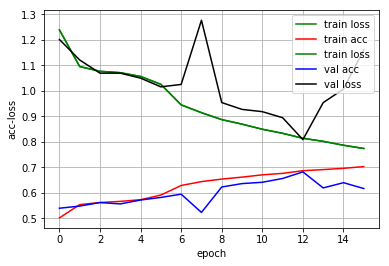

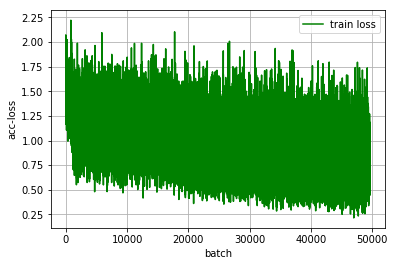

In [13]:
import matplotlib.pyplot as plt
import pickle
to_save={}
to_save['losses']=history.losses
to_save['accuracy']=history.accuracy
to_save['val_loss']=history.val_loss
to_save['val_acc']=history.val_acc
with open('own_model.pickle','wb') as f:
    pickle.dump(to_save,f)
history.loss_plot('epoch')
history.loss_plot('batch')
plt.show()